<a href="https://colab.research.google.com/github/Samini-2/Samini/blob/main/Anomaly_Det_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 1. | LOADING LIBRARIES**

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.18.0


# **STEP 1.1 | IMPORT DATA**

In [ ]:
df = pd.read_csv('/content/spx.csv', parse_dates=['date'], index_col='date')

df.head()

<ipython-input-2-868230d68324>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/spx.csv', parse_dates=['date'], index_col='date')


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


# **STEP 2.| Visualize the time series**

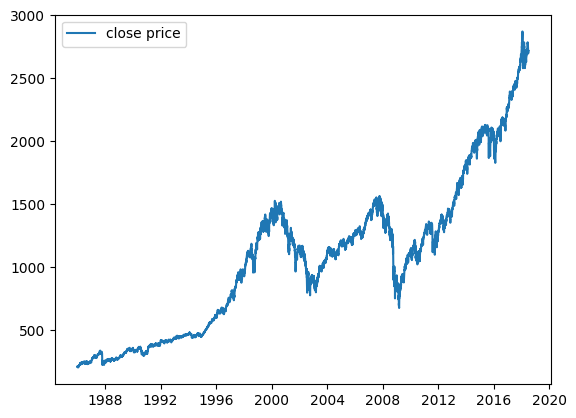

In [ ]:
plt.plot(df, label='close price')
plt.legend()

Over the past years, there has been a promising trend that may present a good investment opportunity. It might be worth considering investing in this trend. However, it's important to determine the best time to buy or sell. Additionally, it's valuable to identify anomalies or sudden changes as early as possible

# **STEP 3.0 | Data Preprocessing**

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

(7782, 1) (410, 1)


<ipython-input-4-2782f44b0353>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-4-2782f44b0353>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [ ]:
def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_seq(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_seq(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


# **STEP 4.0 | Modelling**

# **STEP 4.1**
 | This code defines and compiles a sequence-to-sequence LSTM (Long Short-Term Memory) autoencoder using TensorFlow's Keras API. The model consists of an encoder-decoder structure where the first LSTM layer (with 64 units) processes the input sequentially and captures temporal dependencies. A Dropout layer (20%) is added to prevent overfitting. The RepeatVector layer ensures the output sequence has the same length as the input. The decoder consists of another LSTM layer (64 units, return_sequences=True), which reconstructs the sequence step by step. Another Dropout layer follows to improve generalization. Finally, a TimeDistributed Dense layer is used to predict each time step’s output with the same number of features as the input. The model is compiled using the Mean Absolute Error (MAE) loss and the Adam optimizer for efficient training. This architecture is typically used for anomaly detection or time-series forecasting, where the model learns to reconstruct normal patterns and identifies deviations.**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

The RepeatVector layer duplicates the input n times,
Setting return_sequences=True in the LSTM layer makes it return a sequence.
The TimeDistributed layer creates a - vector with a length equal to the number of outputs from the preceding layer.
By combining these layers, we can create an LSTM Autoencoder that is ready for training.
The training process is similar to that of a regular LSTM model. Finally, we added a TimeDistributed(Dense(X_train.shape[2])) layer at the end of the network to obtain the output, where X_train.shape[2] represents the number of features in the input data

# **STEP 5.0 | Model Training**

In [ ]:
history = model.fit( X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - loss: 0.2843 - val_loss: 0.2874
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.1314 - val_loss: 0.1941
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.1588 - val_loss: 0.1455
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2224 - val_loss: 0.1409
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.2564 - val_loss: 0.1724
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.2320 - val_loss: 0.1538
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.2617 - val_loss: 0.2610
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.2124 - val_loss: 0.2987
Epoch 9/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2395 - val_loss: 0.1666
Epoch 10/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.1969 - val_loss: 0.1526


# **STEP 6 | Evaluation**

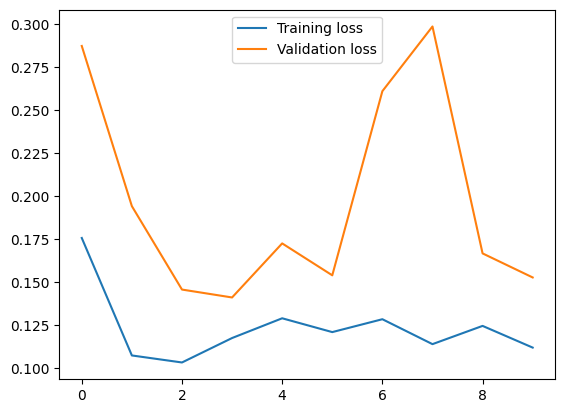

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Validation loss has increased in the end of model training. Callbacks such as Early stopping could be used to avoid this.

In [ ]:
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5331


0.6625159978866577

The output indicates that the evaluation process was carried out on 12 batches, and the average loss on the test set was 0.7052039504051208

The value 0.7052039504051208 printed after the batch-level output is the final loss value returned by the evaluate function. It implies that the model is performing well in terms of detecting anomalies in the test data. A lower loss value indicates better performance.

etecting Anomalies